<h1>Neural CLE Minimum Working Example<h1>

In [52]:
using Distributed
addprocs(96, topology=:master_worker, exeflags="--project=$(Base.active_project())");

In [971]:
@everywhere begin
    using DiffEqFlux
    using SciMLSensitivity
    using Optimization
    using StochasticDiffEq, DiffEqCallbacks, DiffEqNoiseProcess
    using Statistics, LinearAlgebra, Random
    using Plots
    using RecursiveArrayTools
    using DiffEqBase.EnsembleAnalysis
    using BenchmarkTools
    using Pkg
    using LaTeXStrings
    using Plots.PlotMeasures
end

We are interested in the Birth-Death system, which could be used to describe the population dynamics of a system of cells that has both a growth and death term proportional to its current population. The mathematics of the single ODE system are as follows:

$\frac{dX}{dt} = \alpha_1 X - \alpha_2 X$

For our purposes, what we are trying to show is that we can observe parts of the ODE from viewing the final output. So we rearrage this system for convenience (and generalizability)

$\frac{dX}{dt} = R_1 - R_2$

$\frac{dT_1}{dt} = R_1$

$\frac{dT_2}{dt} = R_2$


Where $T_1$ and $T_2$ are cumulative reaction rate curves. If we can predict these T from the observable data (X), it is equivalent to being able to predict the reaction rates.

The CLE of this system would look like:
$\frac{dS}{dt} = \begin{bmatrix}
R_1 - R_2\\
R_1\\
R_2\\
\end{bmatrix} dt + 
\begin{bmatrix}
\sqrt{R_1} & -\sqrt{R_2}\\
\sqrt{R_1} & 0\\
0 & \sqrt{R_2}\\
\end{bmatrix}dW$

Where

$S = \begin{bmatrix}
X\\
T_1\\
T_2\\
\end{bmatrix}$

After we construct training data, the goal is to fit the CLE to the data using a neural network to predict $R_1$ and $R_2$.

To test this case, we will use two different ground truth formulations. First, a case of linear reaction rates

$R_1 = \alpha_1X$

$R_2 = \alpha_2X$

Where $(\alpha_1,\alpha_2) = (0.2,0.1)$. Secondly, we will explore a nonlinear case where 

$R_1 = \frac{k_{app}X}{X+K_M}$

$R_2 = \gamma X$

Where $(k_{app}, K_M, \gamma) = (20,10,0.2)$. The nonlinear expression for $R_1$ in this case is based on the Michaelis-Menten kinetic rate law, which is the most common nonlinear rate expression in biochemistry. 

The following is a representation of one evaluation of the "ground truth" SDE that we will attempt to fit to.

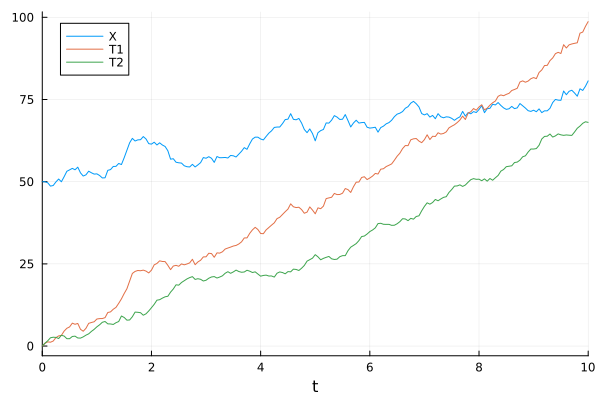

In [757]:
@everywhere begin
    function trueSDEfunc(du, u, p, t)#Function describing the drift term of SDE for linear ground truth test
        R1 = 0.2*u[1]
        R2 = 0.1*u[1]
        #Safety valve to prevent divergence to unstable values
        if u[1]>1000
            du[1] = 0
        else
            du[1] = R1-R2
        end
        du[2] = R1
        du[3] = R2
    end

    function true_noise_func(du, u, p, t)#Function describing the diffusion term for linear case according to formulations of CLE
        R1 = 0.2*u[1]
        R2 = 0.1*u[1]
        du[1, 1] = sqrt.(R1)[1]
        du[1, 2] = -sqrt.(R2)[1]
        du[2, 1] = sqrt.(R1)[1]
        du[3, 2] = 0
        du[3, 1] = 0
        du[3, 2] = sqrt.(R2)[1]
    end

    u0 = Float64[50.; 0.;0] #Initial conditions of B-D system, zeroing out total births and deaths
    datasize = 21 #Number of time-based data points
    tspan = (0.0f0, 10.0f0)#Initial and final time
    tsteps = range(tspan[1], tspan[2], length = datasize)
    dt = tspan[2]/(datasize-1)
end
prob_truesde = SDEProblem(trueSDEfunc, true_noise_func, u0, tspan, noise_rate_prototype = zeros(3, 2))

sol = solve(prob_truesde, EM(), dt=0.05)
plot(sol,label = ["X" "T1" "T2"])

Similarly, we can define functions for the ground truth of the nonlinear ground truth case. 

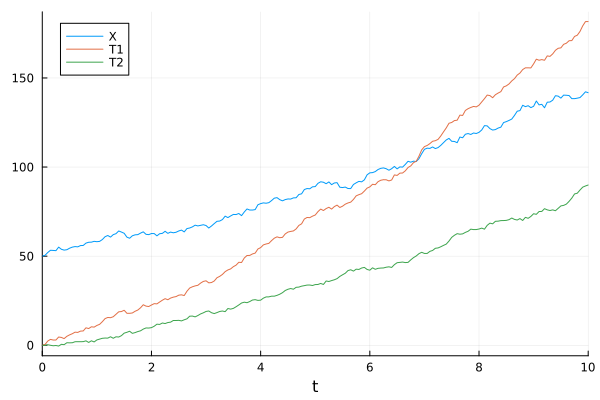

In [758]:
@everywhere begin
    function truenonlinSDEfunc(du, u, p, t)#Function describing the drift term of SDE for nonlinear ground truth test
        R1 = 20*u[1]/(u[1]+10)
        R2 = 0.2*u[1]
        #Safety valve to prevent divergence to unstable values
        if u[1]>1000
            du[1] = 0
        else
            du[1] = R1-R2
        end
        du[2] = R1
        du[3] = R2
    end

    function true_nonlinnoise_func(du, u, p, t)#Nonlinear diffusion function
        R1 = 20*u[1]/(u[1]+10)
        R2 = 0.2*u[1]
        du[1, 1] = sqrt.(R1)[1]
        du[1, 2] = -sqrt.(R2)[1]
        du[2, 1] = sqrt.(R1)[1]
        du[3, 2] = 0
        du[3, 1] = 0
        du[3, 2] = sqrt.(R2)[1]
    end
end
prob_nonlin_truesde = SDEProblem(truenonlinSDEfunc, true_nonlinnoise_func, u0, tspan, noise_rate_prototype = zeros(3, 2))


sol = solve(prob_truesde, EM(), dt=0.05)
plot(sol,label = ["X" "T1" "T2"])

We can generate a consistant testing set of means and variance by averaging an ensemble of function evaluations. For the linear case:

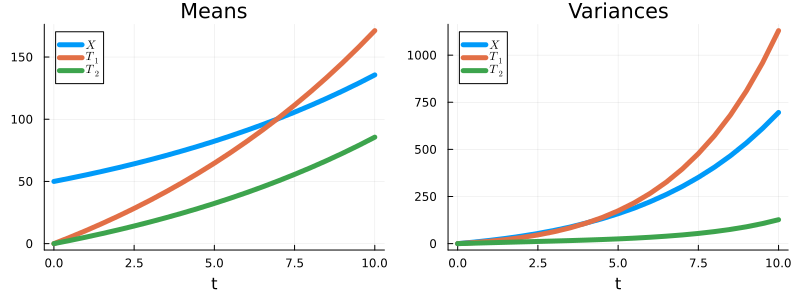

In [1118]:
function getensemblegroundtruth(problem)
    ensembleprob = EnsembleProblem(problem)
    sol = solve(ensembleprob, EM(), EnsembleDistributed(), dt=0.05, saveat = dt, trajectories = 100000)
    truemean = mean(sol, dims = 3)[:, :]
    truevar = var(sol, dims = 3)[:, :];
    plt1 = plot(LinRange(0,10,datasize),truemean',label = [L"X" L"T_1" L"T_2"],title = "Means")
    plt2 = plot(LinRange(0,10,datasize),truevar',label = [L"X" L"T_1" L"T_2"],title = "Variances")
    plt = plot(plt1,plt2,size = (800,300),linewidth = 5,xlabel = "t",bottom_margin = 5mm)
    return truemean,truevar,plt
end

truemeanlinear,truevarlinear, lineargtplot = getensemblegroundtruth(prob_truesde)
lineargtplot

For the nonlinear case:

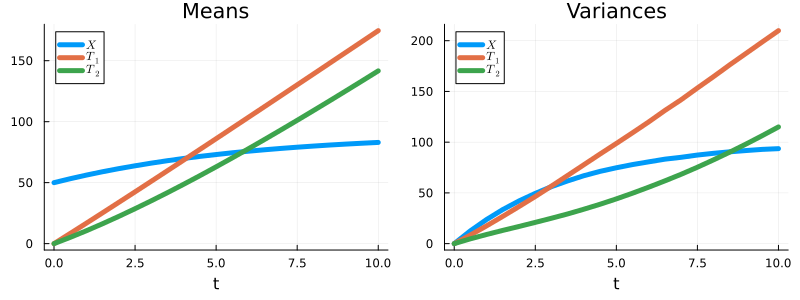

In [1119]:
truemeannonlin,truevarnonlin, nonlineargtplot = getensemblegroundtruth(prob_nonlin_truesde)
savefig(nonlineargtplot,"BDgt.pdf")
nonlineargtplot

Now we generate a neural SDE that can be trained on this data. We want to generate an SDEProblem that takes in two functions describing the drift and diffusion of our system. These functions, in turn, rely on the same neural network (with the same parameters) to predict the rates for them. Note that ratesmodel() only gets to access X.

In [927]:
@everywhere begin
    #NN model that takes in 1 observation (X) and predicts two rates (R1, R2)
    ratesmodel = FastChain((x,p) -> x ./150,FastDense(1 , 16, relu), FastDense(16 , 2, relu),(x,p) -> x .*30)

    function ratestodrift(u, p, t)#NN-based drift function. p here is NN parameter set.
        R1,R2 = ratesmodel(u[1],p)
        R1 = abs(R1*u[1]/50)
        R2 = abs(R2*u[1]/50)
        #Safetly valve to keep bad parameter sets from crashing
        if abs(u[1])<1000
            reacprogress = R1-R2
        else
            reacprogress = 0
        end
        return [reacprogress,R1,R2]
    end

    function ratestodiff(u, p, t)#NN-based diffusion function 
        R1,R2 = ratesmodel(u[1],p)
        R1 = abs(R1*u[1]/50)
        R2 = abs(R2*u[1]/50)
        return [[sqrt.(R1),sqrt.(R1),0] [-sqrt.(R2),0,sqrt.(R2)]]
    end
end

      From worker 3:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.


┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9


      From worker 3:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 5:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 5:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 7:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 7:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 6:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is

      From worker 25:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 15:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 15:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 27:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 27:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 29:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, 

      From worker 56:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 56:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 42:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 42:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 54:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more detail

      From worker 79:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 76:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 76:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 78:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 78:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 81:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, 

We define the neural network using FastChains, which explicitly requires you to pass in a vector of parameters. p_nn is a randomly generated set of parameters that can be used as a starting point. 

In [1133]:
#Define initial parameter "guesses". We will have to make sure these are in the right regime for operation by rerunning this cell. 
p_nn = 2 .*rand(66) .-1; #initial_params(ratesmodel) 

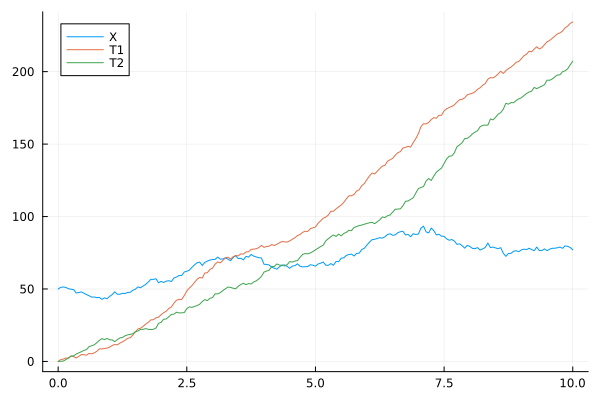

In [928]:
prob = SDEProblem(ratestodrift, ratestodiff, u0, tspan, p_nn, noise_rate_prototype=zeros(3,2))
sol = solve(prob,EM(),dt = 0.05;sensealg=TrackerAdjoint())
plot(sol.t,Array(sol)',label = ["X" "T1" "T2"])

In [1039]:
#Set of functions to assist in model fitting. 
function getprediction(p,u=u0)
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype=zeros(3,2))
    sol = solve(prob,EM(),dt = 0.05,saveat = dt;sensealg=TrackerAdjoint())
     if (sol.retcode != ReturnCode.Success)
         print(p)
     end
    return Array(sol)
end

function predict_batch_neuralsde(p, n)
    res = map((x->getprediction(p,x)),[u0 for i in 1:n])
    VA = VectorOfArray(res)
    arr = convert(Array,VA)
end

function predictmeanvar_ensemble(p, n)
    problem = SDEProblem(ratestodrift, ratestodiff, u0, tspan, p, noise_rate_prototype=zeros(3,2))
    ensembleprob = EnsembleProblem(problem)
    sol = solve(ensembleprob, EM(), EnsembleDistributed(), dt=0.05, saveat = dt, trajectories = n;sensealg=InterpolatingAdjoint())
    truemean = mean(sol, dims = 3)[:, :]
    truevar = var(sol, dims = 3)[:, :];
    if test_success(sol) == false
        print(p)
    end
    return truemean,truevar
end

function test_success(x)
    for i in x
        if i.retcode != ReturnCode.Success
            return false
        end
    end
    return true
end

function predict_batch_neuralsde_parallel(p, n)
    res = ThreadsX.map((x->getprediction(p,x)),[u0 for i in 1:n])
    VA = VectorOfArray(res)
    arr = convert(Array,VA)
end

function predictmeanvar(p,n)
    samples = predict_batch_neuralsde(p,n)
    means = mean(samples, dims = 3)
    vars = var(samples, dims = 3, mean = means)
    return means,vars
end

function loss_neuralsde(p,truemean,truevar,n)
    means,vars = predictmeanvar_ensemble(p,n)
    testmeans = means[1,:,:]
    
    finalbirth = means[2,:,:][end]
    finaldeath = means[3,:,:][end]
    
    testvars = vars[1,:,:]
    loss = sum(abs2, (truemean[1,2:end] .- testmeans[2:end]) ./ (truemean[1,2:end] .- u0[1])) + sqrt(sum(abs2, (truevar[1,2:end] .- testvars[2:end]) ./ truevar[1,2:end]))  + (finalbirth<1)*datasize*(1-finalbirth) + (finaldeath<1)*datasize*(1-finaldeath)#+ sum(abs2, p)
    #println(p)
    println(string(loss))
    return loss#, means, vars
end

function train_model(truemean,truevar,maxiter,startpoint;n=100)
    opt = ADAM(0.0005)
    adtype = Optimization.AutoZygote()
    optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde(x,truemean,truevar,n), adtype)
    optprob = Optimization.OptimizationProblem(optf, startpoint)
    result1 = Optimization.solve(optprob, opt, maxiters = maxiter)
end

function trainingprogress(start,trainingresult,truemean,truevar)
    println("Start Point:")
    loss_neuralsde(start,truemean,truevar,1000) #Inital parameter guess
    println("Training Result:")
    loss_neuralsde(trainingresult.u,truemean,truevar,1000) #Inital parameter guess
    startplot = trainingprogressplot(start,truemean,truevar,false)
    endplot = trainingprogressplot(trainingresult.u,truemean,truevar,true)
    plot(startplot,endplot,size = (800,400))
end

function trainingprogressplot(params,truemean,truevar,trained)
    if trained
            state = "Trained: "
            colorind = 48
    else
            state = "Initial: "
            colorind = 52    
    end
    color = cgrad(:vik, 100, categorical = true)[colorind]
    predres = predictmeanvar_ensemble(params,5000)
    plt1 = plot(tsteps,[truemean[1,:],predres[1][1,:,:]],title=state*"X mean",label = ["Ground Truth" "Prediction"])
    plt2 = plot(tsteps,[truevar[1,:],predres[2][1,:,:]],title=state*"X var",label = ["Ground Truth" "Prediction"])
    plt3 = plot(tsteps,[truemean[2,:],predres[1][2,:,:]],title=state*L"T_1"*" Mean",label = ["Ground Truth" "Prediction"])
    plt4 = plot(tsteps,[truemean[3,:],predres[1][3,:,:]],title=state*L"T_2"*" Mean",label = ["Ground Truth" "Prediction"])
    plot(plt1,plt2,plt3,plt4, layout = (2,2), size = (400,400),linewidth = 3.5,background_color_subplot = color,right_margin = 5mm)
end

#test = Zygote.gradient(x -> loss_neuralsde(x,truemeanlinear,truevarlinear,n=100), problem_p)

trainingprogressplot (generic function with 2 methods)

Now that we have a loss function described, we can train our neural network. I had to set the training rate hyperparameter very low to avoid weird divergence in parameter updates. As such it takes a long time. The plots below shows the results - specifically (hopefully), that as the model converges to the testing data (X means and vars) it also converges to showing the hidden values correctly (R1 and R2 (cumulative)).

In [940]:
nonlineartrainingresult1 = train_model(truemeannonlin,truevarnonlin,100,p_nn,n=1000);

8.547429775408954
8.498079304535164
7.4482765328445
7.3729956052033465
6.690857980626539
6.962188908561291
6.234301032205979
6.568461470935664
5.904210953797662
6.4283788446502985
5.245093017996889
5.331117402783235
4.8475576299889855
5.62283133196882
5.055995299443778
4.941111806261285
4.842069451059274
5.036634899974915
5.453363445476201
4.977901646332397
4.439777503550824
5.078900000354623
4.944299650306095
5.270897685179712
4.28575746157059
5.459195552931993
4.5359221084783705
5.4142267558844415
4.8014357420258085
4.879196577884343
4.60870534952279
4.4559981340791746
4.438968510044623
3.9061927420352034
4.643023139261286
4.420008208834252
4.289323028399772
4.806190290249543
4.047536480510592
4.222594424109173
4.001458337905831
4.47534490594672
3.8184849690005542
3.886778458460178
4.360159256990383
4.22418558363929
3.926762379995596
3.954297261787978
3.851463001534085
3.7558081673858275
4.183497346912816
3.6292056541771447
3.8343801644195126
3.761693498816353
3.80127012598065
3.6629

In [941]:
nonlineartrainingresult2 = train_model(truemeannonlin,truevarnonlin,200,nonlineartrainingresult1.u,n=1000);

0.8299665196068099
0.9405869051277956
0.695248444882427
0.8003108053676327
0.7697815665778075
0.863536863477401
0.6751579129367712
0.8617225949912182
0.7798593170925485
0.9059774874460778
0.9598171810427563
0.7802747902146906
0.7695377732746578
0.7585993902495423
0.7947488297928019
0.5252871975319505
0.5500119377638695
0.6510844592792133
0.7640627673785695
0.542108399054176
0.6630593045859504
0.6980984323874038
0.6773227358463068
0.620629197800297
0.6026695901417785
0.6147349288697861
0.6585917155015788
0.5050699553920988
0.6343185745572015
0.5293659015021545
0.6064427357149075
0.6523471799538506
0.6172383916833257
0.5367018964132522
0.6458390906306994
0.616145068729369
0.5661379034076038
0.6363712404629962
0.68526530246447
0.5997373251684612
0.6375424869561959
0.512012639973383
0.458026619762993
0.4967109227443168
0.6515789496836633
0.5538726252739227
0.521505877292293
0.4891210501120104
0.5626824056029992
0.4473414255130362
0.670154799401834
0.588090661606345
0.5408447577312672
0.657

In [943]:
nonlineartrainingresult3 = train_model(truemeannonlin,truevarnonlin,30,nonlineartrainingresult2.u,n=3000);

0.33580092722534477
0.27047824715101276
0.3343310808932308
0.34766802708903566
0.24836036816547102
0.32909045482925314
0.32814526964325363
0.3108760914447548
0.3019135867658944
0.3646035348831682
0.3597758885346082
0.3757237613024264
0.36355194933733037
0.3482446642621249
0.2892452290651487
0.25686963300873134
0.33601765178196524
0.268648313913336
0.2635624981934009
0.33863172217368526
0.3154267671236889
0.2831310983285833
0.30333715296600783
0.3172274261334395
0.21684892545336448
0.2679729299564978
0.32551245493633035
0.39064281646514193
0.30843407649313986
0.31792924979454357
0.34426987594102554
0.22316662824782085
0.3761778761921826
0.29193713631666496
0.2982049754226813
0.2531548528048542
0.32448079188637224
0.2837100726986501
0.3325429088966473
0.30053294966530897
0.28984752475624376
0.27463652526786353
0.33416212632867104
0.31976864284680134
0.2992265604376921
0.3141998404290526
0.2982148301051273
0.23887918889842638
0.25360062084115015
0.2662728785514537
0.34249384395819277
0.31

Start Point:
569.9977918360273
Training Result:
0.31050232723014065


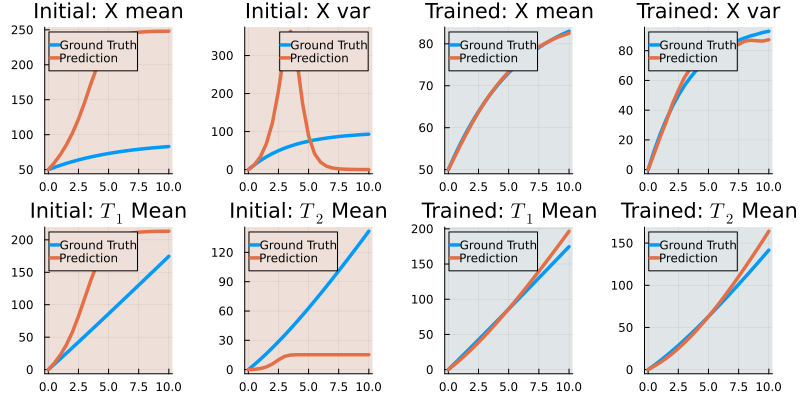

In [1040]:
BDplt = trainingprogress(p_nn_bad,nonlineartrainingresult3,truemeannonlin,truevarnonlin)
savefig(BDplt,"BDmodel.pdf")
BDplt

<b>Part 2: Two-Pool Model<b>

Another classic but structurally non-identifiable system in biology is the decay of a substance that transfers between different compartments. In the case of two compartments, the deterministic two-pool model contains four distinct processes:

$$
\frac{\textrm{d}\mathbf{X}}{\textrm{d}t} = 
\begin{bmatrix}
    R_4(\mathbf{X}) - R_1(\mathbf{X}) - R_3(\mathbf{X}) \\
    R_3(\mathbf{X}) - R_2(\mathbf{X}) - R_4(\mathbf{X})
\end{bmatrix} \in \mathbb{R}_+^2
$$

Given time-series measurements of states $X_1,X_2$, decay rates ($R_1(\mathbf{X}),R_2(\mathbf{X})$) and transfer rates ($R_1(\mathbf{X}),R_2(\mathbf{X})$) of the substance at a particular compartment cannot be uniquely estimated. As in the Birth-Death model, the two-pool model CLE is describes stochasticity due to $\mathbf{W}\in\mathbb{R}^4$ Wiener processes: 

$$
\textrm{d}\mathbf{X} = 
\begin{bmatrix}
    R_4(\mathbf{X}) - R_1(\mathbf{X}) - R_3(\mathbf{X}) \\
    R_3(\mathbf{X}) - R_2(\mathbf{X}) - R_4(\mathbf{X})
\end{bmatrix} \textrm{d}t +
\begin{bmatrix}
    -\sqrt{R_1(\mathbf{X})} & 0 & -\sqrt{R_3(\mathbf{X})} & \sqrt{R_4(\mathbf{X})} \\
    0 & -\sqrt{R_2(\mathbf{X})} & \sqrt{R_3(\mathbf{X})} & -\sqrt{R_4(\mathbf{X})}
\end{bmatrix}\textrm{d}\mathbf{W}
$$
The code below also includes the vector $T$ in the state vector, which represents cumulative reaction progress for each of the four processes in the two-pool model. 

For the purposes of generating training data, the rates are defined as a mixture of linear and Michaelis-Menten Dependencies

$R_1 = 5\frac{X_1}{X_1+20}$

$R_2 = \frac{X_2}{X_2+20}$

$R_3 = 0.2X_1$

$R_4 = 0.1X_2$


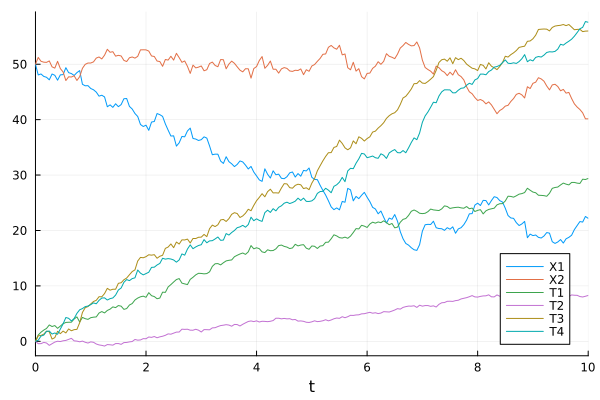

In [439]:
@everywhere begin
    function trueTPSDEfunc(du, u, p, t)#Function describing the drift term of SDE for ground truth test
        R1 = 5*u[1]/(u[1]+20)
        R2 = 1*u[2]/(u[2]+20)
        R3 = 0.2*u[1]
        R4 = 0.1*u[2]
        
        du[1] = R4-R1-R3
        du[2] = R3-R2-R4
        du[3] = R1
        du[4] = R2
        du[5] = R3
        du[6] = R4
    end

    function true_TPnoise_func(du, u, p, t)#Function describing the diffusion term for linear case according to formulations of CLE
        R1 = 5*u[1]/(u[1]+20)
        R2 = 1*u[2]/(u[2]+20)
        R3 = 0.2*u[1]
        R4 = 0.1*u[2]
           
        du[1, 1] = -sqrt.(R1)[1]
        du[1, 2] = 0
        du[1, 3] = -sqrt.(R3)[1]
        du[1, 4] = sqrt.(R4)[1]        
        
        du[2, 1] = 0
        du[2, 2] = -sqrt.(R2)[1]
        du[2, 3] = sqrt.(R3)[1]
        du[2, 4] = -sqrt.(R4)[1]             
        
        du[3, 1] = sqrt.(R1)[1]
        du[4, 2] = sqrt.(R2)[1]        
        du[5, 3] = sqrt.(R3)[1]      
        du[6, 4] = sqrt.(R4)[1]
    end

    u0TP = Float64[50.; 50.;0.;0.;0.;0.] #Initial conditions of B-D system, zeroing out total births and deaths
    datasizeTP = 21 #Number of time-based data points
    tspanTP = (0.0f0, 10.0f0)#Initial and final time
    tstepsTP = range(tspan[1], tspan[2], length = datasize)
    dtTP = tspanTP[2]/(datasize-1)
end
prob_truesdeTP = SDEProblem(trueTPSDEfunc, true_TPnoise_func, u0TP, tspanTP, noise_rate_prototype = zeros(6, 4))

sol = solve(prob_truesdeTP, EM(), dt=0.05)
plot(sol,label = ["X1" "X2" "T1" "T2" "T3" "T4"])

In [1131]:
function getensemblegroundtruthTP(problem)
    ensembleprob = EnsembleProblem(problem)
    sol = solve(ensembleprob, EM(), EnsembleDistributed(), dt=0.05, saveat = dt, trajectories = 100000)
    truemean = mean(sol, dims = 3)[1:3, :]
    truevar = var(sol, dims = 3)[1:3, :];
    truecov = [Statistics.cov([i[1,j] for i in sol],[i[2,j] for i in sol]) for j in 1:datasizeTP]
    plt1 = plot(LinRange(0,10,datasize),truemean',label = [L"X_1" L"X_2" L"T_1"],title = "Means")
    plt2 = plot(LinRange(0,10,datasize),truevar',label = [L"X_1" L"X_2" L"T_1"],title = "Variances")
    plt3 = plot(LinRange(0,10,datasize),truecov,title = L"X1 X2"*" Covariance",label = "")

    plt = plot(plt1,plt2,plt3,size = (800,300),layout = (1,3),linewidth = 5,xlabel = "t",bottom_margin = 5mm)
    return truemean,truevar,truecov,plt
end

getensemblegroundtruthTP (generic function with 1 method)

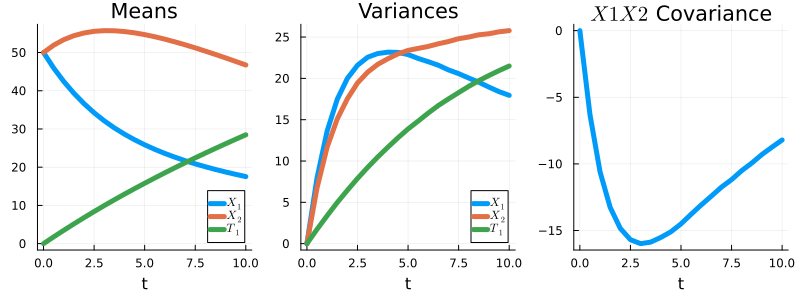

In [1132]:
truemeanTP,truevarTP, truecovTP, TPgtplot = getensemblegroundtruthTP(prob_truesdeTP)
savefig(TPgtplot,"TPgt.pdf")
TPgtplot

In [707]:
@everywhere begin
    #NN model that takes in 1 observation (X) and predicts two rates (R1, R2)
    ratesmodelTP = FastChain((x,p) -> x ./50,FastDense(2 , 16, relu), FastDense(16 , 4, relu),(x,p) -> x .*30)

    function ratestodriftTP(u, p, t)#NN-based drift function. p here is NN parameter set.
        R1,R2,R3,R4 = ratesmodelTP(u[1:2],p)
        
        R1 = R1*u[1]/50
        R2 = R2*u[2]/50
        R3 = R3*u[1]/50
        R4 = R4*u[2]/50
        
        du1 = R4-R1-R3
        du2 = R3-R2-R4
        du3 = R1
        du4 = R2
        du5 = R3
        du6 = R4
        
        return [du1,du2,du3,du4,du5,du6]
    end

    function ratestodiffTP(u, p, t)#NN-based diffusion function 
        R1,R2,R3,R4 = ratesmodelTP(u[1:2],p)
        
        R1 = abs(R1*u[1]/50)
        R2 = abs(R2*u[2]/50)
        R3 = abs(R3*u[1]/50)
        R4 = abs(R4*u[2]/50)
        
        return [[-sqrt.(R1)[1],0,sqrt.(R1)[1],0,0,0] [0,-sqrt.(R2)[1],0,sqrt.(R2)[1],0,0] [-sqrt.(R3)[1],sqrt.(R3)[1],0,0,sqrt.(R3)[1] ,0] [sqrt.(R4)[1],-sqrt.(R4)[1],0,0,0,sqrt.(R4)[1]]]
    end
end

      From worker 2:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 2:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 65:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 65:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 79:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.

┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9



      From worker 70:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 89:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 89:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 73:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 73:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 92:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain,

      From worker 13:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 7:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 7:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 6:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 6:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 11:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but 

      From worker 30:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 30:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 34:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 34:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 33:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more detail

      From worker 44:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 61:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 61:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 68:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, but is fully featured and documented machine learning library. See the Lux.jl documentation for more details.
      From worker 68:	└ @ DiffEqFlux C:\Users\stover\.julia\packages\DiffEqFlux\2IJEZ\src\fast_layers.jl:9
      From worker 52:	┌ Warning: FastChain is being deprecated in favor of Lux.jl. Lux.jl uses functions with explicit parameters f(u,p) like FastChain, 

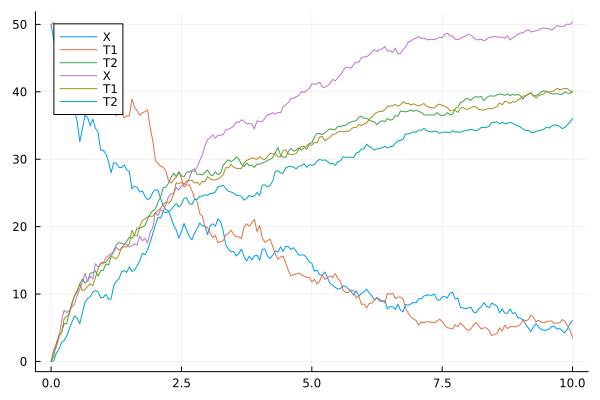

In [728]:
#Define initial parameter "guesses". We will have to make sure these are in the right regime for operation by rerunning this cell. 
p_nnTP = ones(116)*0.1#2 .*rand(116) .-1 #initial_params(ratesmodel) 

prob = SDEProblem(ratestodriftTP, ratestodiffTP, u0TP, tspanTP, p_nnTP, noise_rate_prototype=zeros(6,4))
sol = solve(prob,EM(),dt = 0.05;sensealg=TrackerAdjoint())
plot(sol.t,Array(sol)',label = ["X" "T1" "T2"])

In [1031]:
#Set of functions to assist in model fitting. 
function predictmeanvar_ensembleTP(p, n)
    problem = SDEProblem(ratestodriftTP, ratestodiffTP, u0TP, tspanTP, p, noise_rate_prototype=zeros(6,4))
    ensembleprob = EnsembleProblem(problem)
    sol = solve(ensembleprob, EM(), EnsembleDistributed(), dt=0.05, saveat = dtTP, trajectories = n;sensealg=InterpolatingAdjoint())
    truemean = mean(sol, dims = 3)[:, :]
    truevar = var(sol, dims = 3)[:, :]
    truecov = [Statistics.cov(sol[1,i,:],sol[2,i,:]) for i in 1:datasizeTP]
    #truecov = [sum([i[1,j] for i in sol] .+ [i[2,j] for i in sol]) for j in 1:datasizeTP]

    if test_successTP(sol) == false
        print(p)
    end
    return truemean,truevar,truecov
end

function test_successTP(x)
    for i in x
        if i.retcode != ReturnCode.Success
            return false
        end
    end
    return true
end

function loss_neuralsdeTP(p,truemean,truevar,truecov,n)
    means,vars,cov = predictmeanvar_ensembleTP(p,n)
    testmeans = means[1:2,2:end,:]
    testvars = vars[1:2,2:end,:]
    testcov = cov
    
    loss = sum(abs2, (truemean[1:2,2:end] .- testmeans) ./ (truemean[1:2,2:end] .-50)) + (sum(abs2, (truevar[1:2,2:end] .- testvars) ./ truevar[1:2,2:end])) + sum(abs2, testcov .-truecov)
    #println(p)
    println(string(loss))
    return loss#, means, vars
end

function train_modelTP(truemean,truevar,truecov,maxiter,startpoint;n=100)
    opt = ADAM(0.0001)
    #opt = IPNewton()
    adtype = Optimization.AutoZygote()
    optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsdeTP(x,truemean,truevar,truecov,n), adtype)
    optprob = Optimization.OptimizationProblem(optf, startpoint)
    result1 = Optimization.solve(optprob, opt, maxiters = maxiter)
end

function trainingprogressTP(start,trainingresult,truemean,truevar,truecov)
    println("Start Point:")
    loss_neuralsdeTP(start,truemean,truevar,truecov,30000) #Inital parameter guess
    println("Training Result:")
    loss_neuralsdeTP(trainingresult.u,truemean,truevar,truecov,30000) #Inital parameter guess
    startplot = trainingprogressplotTP(start,truemean,truevar,truecov,false)
    endplot = trainingprogressplotTP(trainingresult.u,truemean,truevar,truecov,true)
    plot(startplot,endplot,size = (800,600))
end

function trainingprogressplotTP(params,truemean,truevar,truecov,trained)
    if trained
            state = "Trained: "
            colorind = 48
    else
            state = "Initial: "
            colorind = 52    
    end
    color = cgrad(:vik, 100, categorical = true)[colorind]
 
    predres = predictmeanvar_ensembleTP(params,30000)
    plt1 = plot(tstepsTP,[truemean[1,:],predres[1][1,:,:]],title=state*L"X_1"*" Mean",label = ["Ground Truth" "Prediction"])
    plt2 = plot(tstepsTP,[truemean[2,:],predres[1][2,:,:]],title=state*L"X_2"*" Mean",label = ["Ground Truth" "Prediction"])
    
    plt3 = plot(tstepsTP,[truevar[1,:],predres[2][1,:,:]],title=state*L"X_1"*" Var",label = ["Ground Truth" "Prediction"])
    plt4 = plot(tstepsTP,[truevar[2,:],predres[2][2,:,:]],title=state*L"X_2"*" Var",label = ["Ground Truth" "Prediction"])
 
    plt5 = plot(tstepsTP,[truecov,predres[3]],title=state*L"X_1 X_2"*" Cov",label = ["Ground Truth" "Prediction"])
    plt6 = plot(tstepsTP,[truemean[3,:],predres[1][3,:,:]],title=state*L"T_1"*" Mean",label = ["Ground Truth" "Prediction"])

    plot(plt1,plt2,plt3,plt4,plt5,plt6, layout = (3,2), size = (400,600),linewidth = 3.5,background_color_subplot = color,right_margin = 5mm)
end

trainingprogressplotTP (generic function with 3 methods)

In [729]:
TPtrainingresult = train_modelTP(truemeanTP,truevarTP, truecovTP,50,p_nnTP;n=100)

26458.538954654276
27002.40347798639
26323.108389472844
26316.993860117673
25562.779710869527
26448.339838873955
25551.841479481973
25463.339285288697
25505.655911578004
25011.56870407172
25012.803342711082
25088.27430129735
24533.680929279835
24245.273999289435
23828.087561229593
24521.997933934785
23317.7045942436
23708.175449656792
22786.537586627914
23070.437538735263
22985.837450050607
22686.721237738846
22915.171924864197
22118.980617924306
21770.641197892935
21928.816124595727
21956.756073875273
21624.996078331365
20751.59927854514
20978.230612690157
20286.5992374075
20705.53860737192
19454.942947133142
20125.373134252968
20186.130344256097
19928.960917298587
18512.918858644807
19050.011242596924
18405.902086960687
18554.12978824357
18236.775520153715
17896.411901109335
17865.17325103179
17849.42142723493
16612.847421212788
17060.137287385805
16156.401048935999
16341.378627813196
15499.207091229344
16428.06446245533
15012.74839829074
15193.420054779988
14674.666987648738
15055.8

u: 116-element Vector{Float64}:
 0.04891392605543106
 0.04891392605543106
 0.04891392605543106
 0.04891392605543106
 0.04891392605543106
 0.04891392605543106
 0.04891392605543106
 0.04891392605543106
 0.04891392605543106
 0.04891392605543106
 0.04891392605543106
 0.04891392605543106
 0.04891392605543106
 ⋮
 0.05033983727855261
 0.04739175002889042
 0.14730483923796686
 0.04776077887600626
 0.05033983727855261
 0.04739175002889042
 0.14730483923796686
 0.04776077887600626
 0.04852327185898432
 0.04587421372372705
 0.14873896720480517
 0.046461205785934725

In [730]:
TPtrainingresult2 = train_modelTP(truemeanTP,truevarTP, truecovTP,100,TPtrainingresult.u;n=100)

2374.216542248476
2891.6490796742296
1960.345769017215
1994.3233449501513
1729.6723354668063
2050.7695658899584
1575.1920300087945
1286.6370585793127
1461.7719662610052
1462.9909956219358
736.6370608698893
933.718487440033
938.3728173990029
600.9380486525099
588.9893992649322
707.9381240699147
553.5653858868058
441.8572414657327
290.70102208265706
656.8173347208271
391.7442179852678
173.5468604331475
103.85752764073943
395.6435918573156
208.41240698139345
160.4914132939781
184.4626657087869
843.5583713184919
202.60833107450495
235.23905128907364
209.35730619394258
271.19500027771437
215.30694889045674
386.9353756396025
400.0529026406084
111.21294478358399
315.5079304964348
566.8958250788894
203.43592295685184
232.95191729488954
514.0909248248549
494.1384154663059
225.83020118482435
269.985880149217
529.7834051410605
414.1279113177304
166.13636597876305
202.94904517969846
290.1804559636677
177.75482644173726
314.95061430122996
341.7505950433241
89.34044346487025
96.56366159650076
124.94

u: 116-element Vector{Float64}:
 0.030013532125882786
 0.030013532125882786
 0.030013532125882786
 0.030013532125882786
 0.030013532125882786
 0.030013532125882786
 0.030013532125882786
 0.030013532125882786
 0.030013532125882786
 0.030013532125882786
 0.030013532125882786
 0.030013532125882786
 0.030013532125882786
 ⋮
 0.026277026561430303
 0.03402239519374202
 0.1511344604628304
 0.05006762161940398
 0.026277026561430303
 0.03402239519374202
 0.1511344604628304
 0.05006762161940398
 0.02200796731202508
 0.03275067768598736
 0.14951330518986122
 0.05155056832563503

In [735]:
TPtrainingresult3 = train_modelTP(truemeanTP,truevarTP, truecovTP,50,TPtrainingresult2.u;n=500)

34.91630098485606
21.225593289721903
17.927370281433628
35.458630577994235
54.77448238486735
43.62635196674005
41.097620752234846
21.84830171246445
14.835234795125096
43.46228585309555
40.17636755848241
42.01442455909215
28.354324181468343
44.78366481308357
64.55522137765966
37.50998577408077
21.0284685978722
29.157103150412116
49.573722726161364
13.091697507310968
19.37867686320572
34.2006051503966
44.87113603489725
37.45251580968677
13.301579674800093
15.51239332611344
35.606173031669094
31.755647022009082
29.45384912012628
41.54024295553854
20.281590379660315
37.55841876301755
39.200110146500684
30.894957703431658
45.945684280642574
9.871748536388909
37.128157109395175
25.06416158455549
31.592831320548328
30.739023728839392
40.25657484998616
25.759438683877597
17.34505786901862
13.8128226200627
17.780242570688948
20.414050061506746
50.84045547707327
20.08926273266468
16.442079430487478
10.802794153485436
16.646790018696926
14.790660598548302
17.842994625659948
22.785729287630282
40.

u: 116-element Vector{Float64}:
 0.027896678731553753
 0.027896678731553753
 0.027896678731553753
 0.027896678731553753
 0.027896678731553753
 0.027896678731553753
 0.027896678731553753
 0.027896678731553753
 0.027896678731553753
 0.027896678731553753
 0.027896678731553753
 0.027896678731553753
 0.027896678731553753
 ⋮
 0.022850633440374944
 0.03365307152017681
 0.1520737081466204
 0.052940428115419415
 0.022850633440374944
 0.03365307152017681
 0.1520737081466204
 0.052940428115419415
 0.019072344850505168
 0.032711142567319426
 0.1506906436992926
 0.05377809837867025

In [747]:
TPtrainingresult4 = train_modelTP(truemeanTP,truevarTP, truecovTP,50,TPtrainingresult3.u;n=200)

18.457696990494664
16.209826966742686
19.312886534386823
28.72295515883249
9.964366299180327
22.06017708341874
11.74598683938772
24.907489906316123
12.713005039912993
19.15207179546382
21.64004419633385
23.8452113744276
14.814874056580766
17.006501849529204
5.261695176185407
14.26285512344012
25.59346233436245
10.613675474205552
12.595732284087568
18.169767064531605
11.00834925190936
13.185767306087849
8.207342166913554
10.066576864974481
8.950455647781505
10.832628596553986
13.88456382120612
7.310015290954549
3.825470957125038
5.629508350457909
17.849934444322688
7.369948555889755
9.356618108489492
3.6303876486328113
8.548486257865642
6.208875054692847
9.304896975263643
7.213763056874184
10.730001508981196
12.251637970113864
4.695188393753564
21.12728487616642
8.282906145741904
16.658535406174988
25.09798335516137
15.041356471622574
10.06498501293401
10.12416805406961
3.9644874580653227
18.028639919225075
9.338908133565994
23.722471385664356
18.313133156157917
8.694786996274328
5.8883

u: 116-element Vector{Float64}:
 0.02713188003236227
 0.02713188003236227
 0.02713188003236227
 0.02713188003236227
 0.02713188003236227
 0.02713188003236227
 0.02713188003236227
 0.02713188003236227
 0.02713188003236227
 0.02713188003236227
 0.02713188003236227
 0.02713188003236227
 0.02713188003236227
 ⋮
 0.022428719962616344
 0.033617737387739634
 0.1545342454392216
 0.05271637158032313
 0.022428719962616344
 0.033617737387739634
 0.1545342454392216
 0.05271637158032313
 0.01927187051969712
 0.033006911118110716
 0.15334239640975994
 0.05303595679831549

In [750]:
TPtrainingresult5 = train_modelTP(truemeanTP,truevarTP, truecovTP,200,TPtrainingresult4.u;n=5000)

8.788208207807688
7.658879827649255
6.5613009882278455
9.17852719686975
17.932474078763565
21.47059910516162
5.0884783453849645
5.581753485427375
8.548243964598694
6.0695906286869
9.619515157768966
12.391437719621322
12.366527957149085
8.354796551384764
5.398917956125763
16.540789985692193
6.535112154853746
7.909215856553528
12.159057254893646
8.210569962479589
6.386707652594307
12.127972291143736
12.065401917048518
4.641146790769527
9.5139483768851
18.15195650470776
6.579386221128676
11.8744260393368
4.496390150142265
6.615531104878146
11.49887447271802
5.044561918233606
9.01793855012918
5.364027595326007
10.540462609872083
6.76868676821002
8.343109025378379
9.726712017546475
4.860821290795751
11.912639632473235
7.639883450246671
3.6029266243941196
7.758296555374247
8.623712794803946
6.625758754626978
5.513977083364347
8.688511607713034
13.806385580900242
5.0169118044070125
5.839355529529263
4.68026771236716
2.2469857058332217
9.057400512293832
6.2048904772522615
4.513231486403315
6.9

u: 116-element Vector{Float64}:
 0.0015876154849697123
 0.0015876154849697123
 0.0015876154849697123
 0.0015876154849697123
 0.0015876154849697123
 0.0015876154849697123
 0.0015876154849697123
 0.0015876154849697123
 0.0015876154849697123
 0.0015876154849697123
 0.0015876154849697123
 0.0015876154849697123
 0.0015876154849697123
 ⋮
 0.01675560639820646
 0.03671947536252638
 0.15809433045282864
 0.05236563274607238
 0.01675560639820646
 0.03671947536252638
 0.15809433045282864
 0.05236563274607238
 0.017330300668999717
 0.03885086534829645
 0.1574099736930711
 0.04933458829927883

In [987]:
TPtrainingresult6 = train_modelTP(truemeanTP,truevarTP, truecovTP,100,TPtrainingresult5.u;n=10000)

1.8874958900920091
3.301830562756411
15.959285651761613
15.818989841906493
4.971349884950407
3.5953784525040007
4.715895573642846
5.435162222965667
11.046678566172673
9.537571212886867
9.058874476792061
9.581079411744053
2.5247696543187765
2.959187948388816
4.44324390550004
4.133188874530295
4.898651190309506
6.738923618734243
6.550152106927543
6.8669977191136
6.507225685602728
5.975969400578242
2.9215843682146625
4.019620910287189
3.280102377447771
1.6569241871364575
3.0150341292802576
6.0030614511992235
3.983918639219438
4.959419503605563
4.218220835410337
8.331266664662174
2.894179235819702
2.8839806447777008
3.1556415808746374
3.2304668827310388
2.0828946415469813
3.6153808074361184
2.96484006995972
2.976853925415571
4.325655315777682
4.121153839310815
4.3878287769725075
2.8183881620159794
6.1994184324803925
3.721524342738461
1.559086981373739
1.8416777163909974
2.2097969340859946
2.6720296593996373
3.4574355253628886
3.5408812687685614
3.0694336980804175
3.24565473613254
6.4195530

u: 116-element Vector{Float64}:
 -0.0018018180312205955
 -0.0018018180312205955
 -0.0018018180312205955
 -0.0018018180312205955
 -0.0018018180312205955
 -0.0018018180312205955
 -0.0018018180312205955
 -0.0018018180312205955
 -0.0018018180312205955
 -0.0018018180312205955
 -0.0018018180312205955
 -0.0018018180312205955
 -0.0018018180312205955
  ⋮
  0.01613500709375594
  0.0368961994415697
  0.15850951805579844
  0.05236221631041237
  0.01613500709375594
  0.0368961994415697
  0.15850951805579844
  0.05236221631041237
  0.017093420881470207
  0.039453733113228535
  0.15718718809387147
  0.04939114587220064

In [1025]:
TPtrainingresult7 = train_modelTP(truemeanTP,truevarTP, truecovTP,10,TPtrainingresult6.u;n=30000)

2.1818151414376037
2.2247224597281963
2.1659830160812854
1.9288976885594755
1.6818253520072899
1.2777512276216267
2.4506182599107156
1.7769400877030308
3.1431485173675857
2.1841643159507367
2.5237847034091825
2.0068123036465653
1.8154574521567186
2.033470660457472
1.4075879011185046
1.6693682067348279
2.290779685562205
2.599012582515546
1.642140678481856
1.7800399714037538


u: 116-element Vector{Float64}:
 -0.0018937942907349611
 -0.0018937942907349611
 -0.0018937942907349611
 -0.0018937942907349611
 -0.0018937942907349611
 -0.0018937942907349611
 -0.0018937942907349611
 -0.0018937942907349611
 -0.0018937942907349611
 -0.0018937942907349611
 -0.0018937942907349611
 -0.0018937942907349611
 -0.0018937942907349611
  ⋮
  0.016088092948922276
  0.03683487215999988
  0.15867416574837856
  0.05223939973528471
  0.016088092948922276
  0.03683487215999988
  0.15867416574837856
  0.05223939973528471
  0.01705039037392546
  0.03939470715038291
  0.1573536433827814
  0.049246835861069226

Start Point:
26318.372995473695
Training Result:
2.4941707718420645


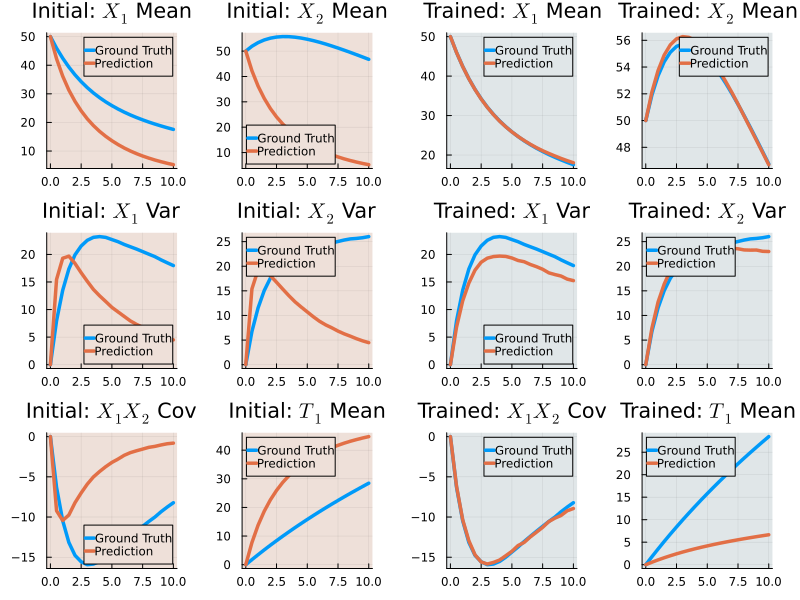

In [1034]:
TPplt = trainingprogressTP(p_nnTP,TPtrainingresult7,truemeanTP,truevarTP, truecovTP)
savefig(TPplt,"TPmodel.pdf")
TPplt

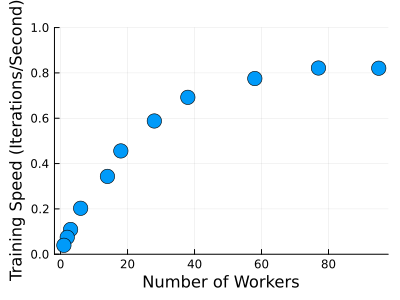

In [1111]:
workersv = [95,77,58,38,28,18,14,6,3,2,1]
timesv = [1.2186262,1.21729792,1.29013956,1.44463858,1.70113314,2.1941021000000003,2.91231546,4.931980333333333,9.162454066666667,13.4093151,25.3940502]
parallelplot = scatter(workersv,1 ./timesv,xlabel = "Number of Workers",ylabel = "Training Speed (Iterations/Second)",yrange = [0,1],label = "",markersize = 8,size = (400,300),top_margin = 5mm)
savefig(parallelplot,"parallel.pdf")
parallelplot